In [55]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import log_loss, make_scorer

In [56]:
train_df = pd.read_csv('Dataset/MultiClassPredictionOfCirrhosisOutcomes/train.csv', encoding='utf-8')
test_df = pd.read_csv('Dataset/MultiClassPredictionOfCirrhosisOutcomes/test.csv', encoding='utf-8')
submission_df = pd.read_csv('Dataset/MultiClassPredictionOfCirrhosisOutcomes/sample_submission.csv', encoding='utf-8')
original_df = pd.read_csv('Dataset/MultiClassPredictionOfCirrhosisOutcomes/cirrhosis.csv', encoding='utf-8')
train_df.shape, test_df.shape, original_df.shape

((7905, 20), (5271, 19), (418, 20))

In [57]:
# Check null values
print(f'Total null in Train data: {sum(train_df.isnull().sum())}')
print(f'Total null in Testing data: {sum(test_df.isnull().sum())}')
print(f'Total null in Original data: {sum(original_df.isnull().sum())}')

Total null in Train data: 0
Total null in Testing data: 0
Total null in Original data: 1033


In [58]:
original_df.isnull().sum()

ID                 0
N_Days             0
Status             0
Drug             106
Age                0
Sex                0
Ascites          106
Hepatomegaly     106
Spiders          106
Edema              0
Bilirubin          0
Cholesterol      134
Albumin            0
Copper           108
Alk_Phos         106
SGOT             106
Tryglicerides    136
Platelets         11
Prothrombin        2
Stage              6
dtype: int64

In [59]:
original_df.dropna(inplace=True)
print(sum(original_df.isnull().sum()))

0


In [60]:
train_df.head(5)

,id,N_Days,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage,Status
0,0,999,D-penicillamine,21532,M,N,N,N,N,2.3,316.0,3.35,172.0,1601.0,179.80,63.0,394.0,9.7,3.0,D
1,1,2574,Placebo,19237,F,N,N,N,N,0.9,364.0,3.54,63.0,1440.0,134.85,88.0,361.0,11.0,3.0,C
2,2,3428,Placebo,13727,F,N,Y,Y,Y,3.3,299.0,3.55,131.0,1029.0,119.35,50.0,199.0,11.7,4.0,D
3,3,2576,Placebo,18460,F,N,N,N,N,0.6,256.0,3.50,58.0,1653.0,71.30,96.0,269.0,10.7,3.0,C
4,4,788,Placebo,16658,F,N,Y,N,N,1.1,346.0,3.65,63.0,1181.0,125.55,96.0,298.0,10.6,4.0,C


In [61]:
original_df.head(5)

,ID,N_Days,Status,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,1,400,D,D-penicillamine,21464,F,Y,Y,Y,Y,14.5,261.0,2.60,156.0,1718.0,137.95,172.0,190.0,12.2,4.0
1,2,4500,C,D-penicillamine,20617,F,N,Y,Y,N,1.1,302.0,4.14,54.0,7394.8,113.52,88.0,221.0,10.6,3.0
2,3,1012,D,D-penicillamine,25594,M,N,N,N,S,1.4,176.0,3.48,210.0,516.0,96.10,55.0,151.0,12.0,4.0
3,4,1925,D,D-penicillamine,19994,F,N,Y,Y,S,1.8,244.0,2.54,64.0,6121.8,60.63,92.0,183.0,10.3,4.0
4,5,1504,CL,Placebo,13918,F,N,Y,Y,N,3.4,279.0,3.53,143.0,671.0,113.15,72.0,136.0,10.9,3.0


In [62]:
train_df.drop(columns=['id'], axis=1, inplace=True)
original_df.drop(columns=['ID'], axis=1, inplace=True)

In [63]:
combined_df = pd.concat([train_df, original_df], ignore_index=True)
combined_df.shape

(8181, 19)

In [64]:
combined_df.duplicated().sum()

0

In [65]:
combined_df.info

<bound method DataFrame.info of       N_Days             Drug    Age Sex Ascites Hepatomegaly Spiders Edema  \
0        999  D-penicillamine  21532   M       N            N       N     N   
1       2574          Placebo  19237   F       N            N       N     N   
2       3428          Placebo  13727   F       N            Y       Y     Y   
3       2576          Placebo  18460   F       N            N       N     N   
4        788          Placebo  16658   F       N            Y       N     N   
...      ...              ...    ...  ..     ...          ...     ...   ...   
8176    1153  D-penicillamine  22347   F       N            Y       N     N   
8177     994          Placebo  21294   F       N            N       N     N   
8178     939  D-penicillamine  22767   F       N            N       N     N   
8179     839  D-penicillamine  13879   F       N            N       N     N   
8180     788          Placebo  12109   F       N            N       Y     N   

      Bilirubin  Ch

In [66]:
combined_df.describe().T

,count,mean,std,min,25%,50%,75%,max
N_Days,8181.0,2028.452512,1094.820580,41.00,1230.00,1831.00,2689.00,4795.00
Age,8181.0,18366.944994,3685.501456,9598.00,15574.00,18701.00,20684.00,28650.00
Bilirubin,8181.0,2.619423,3.844169,0.30,0.70,1.10,3.00,28.00
Cholesterol,8181.0,351.260237,196.856060,120.00,248.00,299.00,392.00,1775.00
Albumin,8181.0,3.547260,0.348327,1.96,3.35,3.58,3.77,4.64
Copper,8181.0,84.471825,76.403770,4.00,39.00,63.00,102.00,588.00
Alk_Phos,8181.0,1822.813348,1911.409689,289.00,834.00,1181.00,1857.00,13862.40
SGOT,8181.0,114.925595,49.105416,26.35,75.95,108.50,137.95,457.25
Tryglicerides,8181.0,115.665322,53.034271,33.00,84.00,104.00,139.00,598.00
Platelets,8181.0,265.112333,87.658802,62.00,210.00,265.00,316.00,563.00


In [67]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8181 entries, 0 to 8180
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Days         8181 non-null   int64  
 1   Drug           8181 non-null   object 
 2   Age            8181 non-null   int64  
 3   Sex            8181 non-null   object 
 4   Ascites        8181 non-null   object 
 5   Hepatomegaly   8181 non-null   object 
 6   Spiders        8181 non-null   object 
 7   Edema          8181 non-null   object 
 8   Bilirubin      8181 non-null   float64
 9   Cholesterol    8181 non-null   float64
 10  Albumin        8181 non-null   float64
 11  Copper         8181 non-null   float64
 12  Alk_Phos       8181 non-null   float64
 13  SGOT           8181 non-null   float64
 14  Tryglicerides  8181 non-null   float64
 15  Platelets      8181 non-null   float64
 16  Prothrombin    8181 non-null   float64
 17  Stage          8181 non-null   float64
 18  Status  

In [68]:
combined_df['Age'] = combined_df['Age'] // 365
combined_df['N_Days'] = combined_df['N_Days'] // 365
combined_df.rename(columns={'N_Days': 'N_Years'}, inplace=True)
combined_df.describe().T

,count,mean,std,min,25%,50%,75%,max
N_Years,8181.0,5.058550,3.028813,0.00,3.00,5.00,7.00,13.00
Age,8181.0,49.824594,10.105503,26.00,42.00,51.00,56.00,78.00
Bilirubin,8181.0,2.619423,3.844169,0.30,0.70,1.10,3.00,28.00
Cholesterol,8181.0,351.260237,196.856060,120.00,248.00,299.00,392.00,1775.00
Albumin,8181.0,3.547260,0.348327,1.96,3.35,3.58,3.77,4.64
Copper,8181.0,84.471825,76.403770,4.00,39.00,63.00,102.00,588.00
Alk_Phos,8181.0,1822.813348,1911.409689,289.00,834.00,1181.00,1857.00,13862.40
SGOT,8181.0,114.925595,49.105416,26.35,75.95,108.50,137.95,457.25
Tryglicerides,8181.0,115.665322,53.034271,33.00,84.00,104.00,139.00,598.00
Platelets,8181.0,265.112333,87.658802,62.00,210.00,265.00,316.00,563.00


In [69]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8181 entries, 0 to 8180
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   N_Years        8181 non-null   int64  
 1   Drug           8181 non-null   object 
 2   Age            8181 non-null   int64  
 3   Sex            8181 non-null   object 
 4   Ascites        8181 non-null   object 
 5   Hepatomegaly   8181 non-null   object 
 6   Spiders        8181 non-null   object 
 7   Edema          8181 non-null   object 
 8   Bilirubin      8181 non-null   float64
 9   Cholesterol    8181 non-null   float64
 10  Albumin        8181 non-null   float64
 11  Copper         8181 non-null   float64
 12  Alk_Phos       8181 non-null   float64
 13  SGOT           8181 non-null   float64
 14  Tryglicerides  8181 non-null   float64
 15  Platelets      8181 non-null   float64
 16  Prothrombin    8181 non-null   float64
 17  Stage          8181 non-null   float64
 18  Status  

In [70]:
categorical_columns = combined_df.select_dtypes(include=['object']).columns.tolist()
numerical_columns = combined_df.select_dtypes(exclude=['object']).columns.tolist()
print(f'Categorical columns: {categorical_columns}')
print(f'Numerical columns: {numerical_columns}')

Categorical columns: ['Drug', 'Sex', 'Ascites', 'Hepatomegaly', 'Spiders', 'Edema', 'Status']
Numerical columns: ['N_Years', 'Age', 'Bilirubin', 'Cholesterol', 'Albumin', 'Copper', 'Alk_Phos', 'SGOT', 'Tryglicerides', 'Platelets', 'Prothrombin', 'Stage']


In [71]:
le = LabelEncoder()
for colum in categorical_columns:
    combined_df[colum]=le.fit_transform(combined_df[colum])

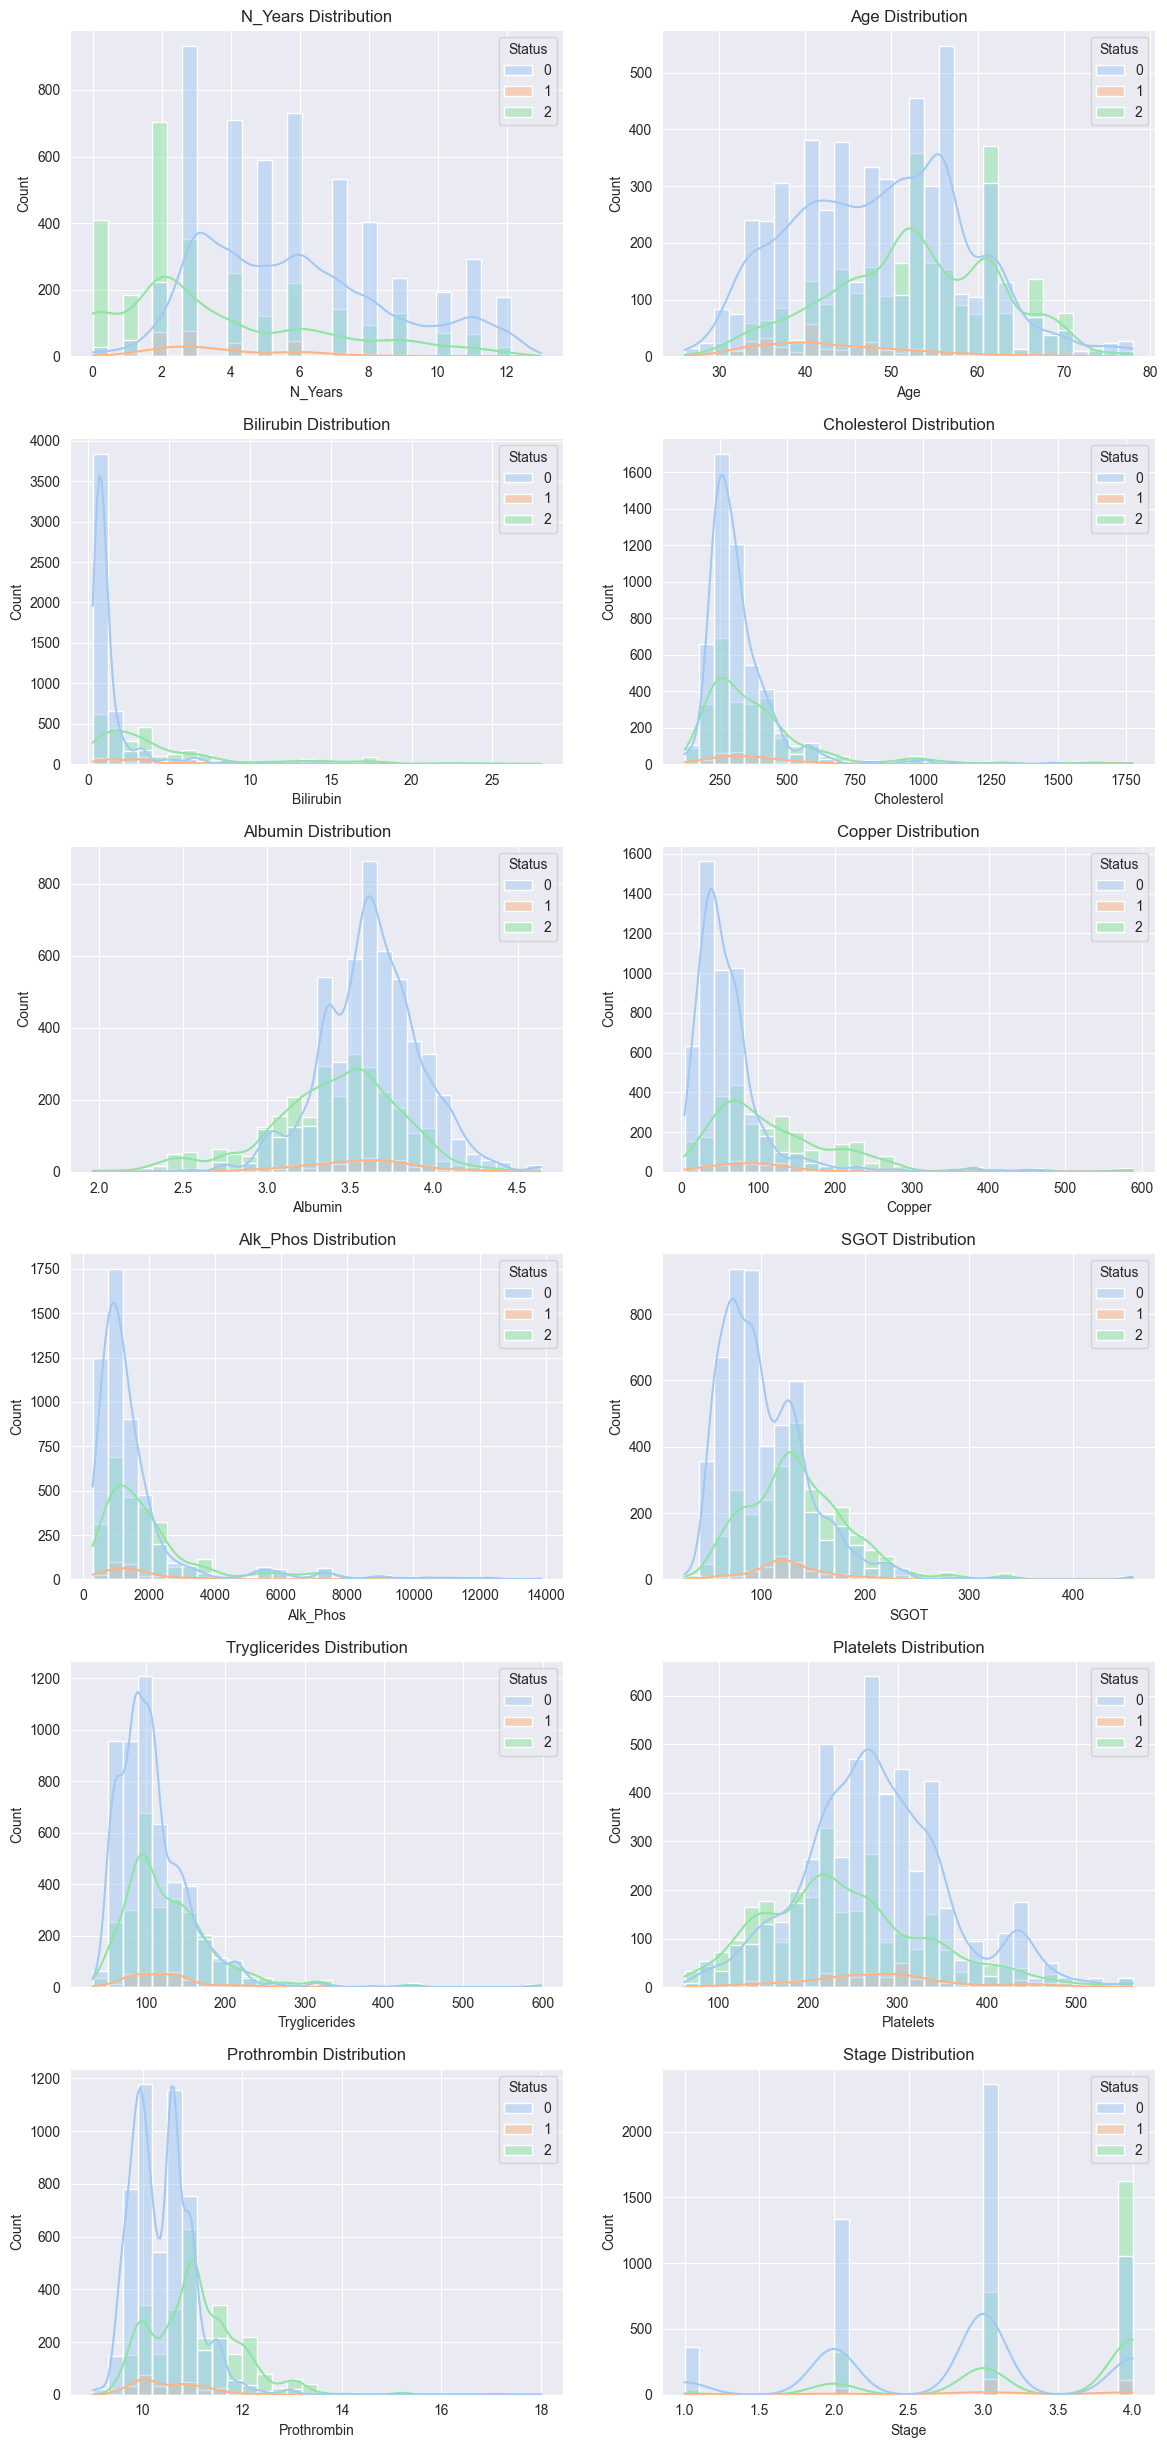

In [72]:
column_names = numerical_columns
plt.figure(figsize=(14,len(column_names)*3))
for idx,column in enumerate(column_names):
    plt.subplot(len(column_names)//2+1,2,idx+1)
    sns.histplot(x=column, hue="Status", data=combined_df,bins=30,kde=True, palette="pastel")
    plt.title(f"{column} Distribution")
    plt.subplots_adjust(wspace=0.20, hspace=0.25)

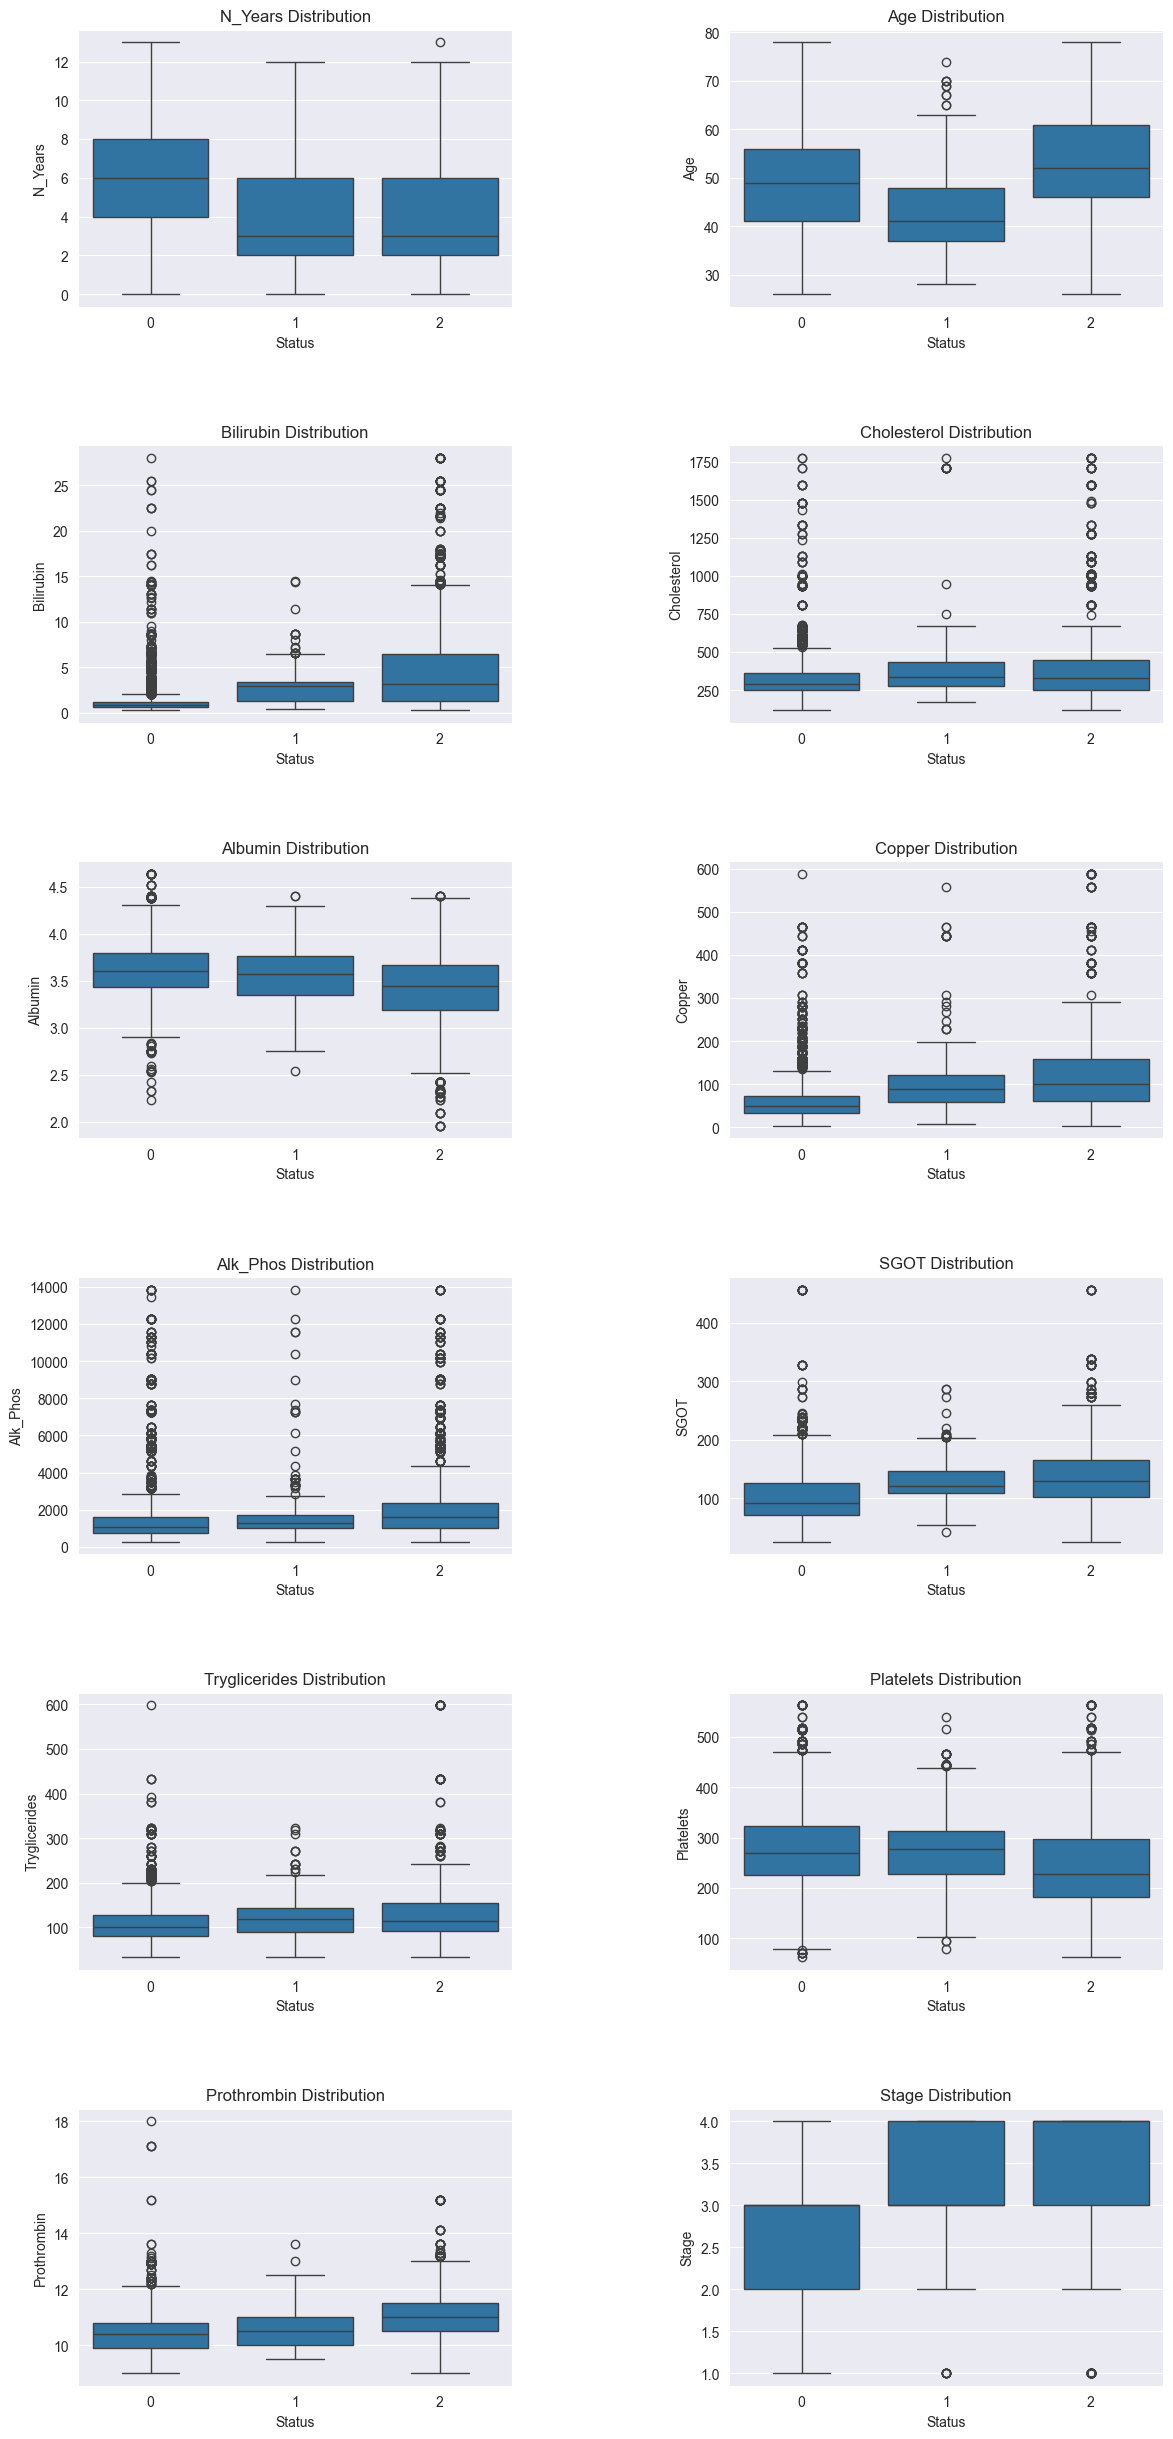

In [73]:
column_names = numerical_columns
plt.figure(figsize=(14,len(column_names)*3))
for idx, column in enumerate(column_names):
    plt.subplot(len(column_names) // 2 + 1, 2,idx + 1)
    sns.boxplot(x="Status", y = column, data=combined_df)
    plt.title(f"{column} Distribution")
    plt.subplots_adjust(wspace=0.5, hspace=0.5)
plt.show()

In [74]:
X = combined_df.drop('Status', axis=1)
y = combined_df['Status']

In [75]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=42)

In [76]:
for col in categorical_columns:
    cat_feature_indices = [combined_df.columns.get_loc(col)]
cat_columns= categorical_columns[:-1]

In [77]:
models = [
    ('CatBoost', CatBoostClassifier(iterations=300, random_seed=42, logging_level='Silent', cat_features=cat_columns)),
    ('Gradient_Boosting', GradientBoostingClassifier(n_estimators=150, random_state=42)),
    ('LightGBM',   LGBMClassifier(n_estimators=150, random_state=42, categorical_feature=cat_feature_indices))
]

In [78]:
sum_prediction=0
# Train and evaluate each model
for model_name, model in models:
    model.fit(X_train, y_train)
    predictions = model.predict_proba(X_test)
    sum_prediction= predictions + sum_prediction
    loss = log_loss(y_test, predictions)
    print(f'Log Loss - {model_name}: {loss}')

Ensemble_pred= sum_prediction/5
Ensemble_logloss= log_loss(y_test, Ensemble_pred)
print(f'Log Loss - Ensemble: {Ensemble_logloss}')

Log Loss - CatBoost: 0.4492220979402408
Log Loss - Gradient_Boosting: 0.44088315520912086
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000690 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1507
[LightGBM] [Info] Number of data points in the train set: 6544, number of used features: 18
[LightGBM] [Info] Start training from score -0.469026
[LightGBM] [Info] Start training from score -3.322472
[LightGBM] [Info] Start training from score -1.083748


/opt/homebrew/Caskroom/miniforge/base/envs/ml_Kaggle/lib/python3.10/site-packages/lightgbm/basic.py:1873: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


Log Loss - LightGBM: 0.4805895959931302
Log Loss - Ensemble: 0.4370733321926966


/opt/homebrew/Caskroom/miniforge/base/envs/ml_Kaggle/lib/python3.10/site-packages/sklearn/metrics/_classification.py:2922: UserWarning: The y_pred values do not sum to one. Starting from 1.5 thiswill result in an error.
  warnings.warn(


In [79]:
test_df= test_df.drop('id', axis=1)
test_df['Age'] = test_df['Age'] // 365.25
test_df['N_Days'] = test_df['N_Days'] // 365.25
test_df.rename(columns={'N_Days': 'N_Years'}, inplace=True)

for colum in cat_columns:
    test_df[colum]=le.fit_transform(test_df[colum])


In [80]:
X_train = combined_df.drop('Status', axis=1)
y_train = combined_df['Status']
X_test = test_df

sum_predictions=0
for model_name, model in models:
    model.fit(X_train, y_train)
    predictions = model.predict_proba(X_test)
    sum_predictions=sum_predictions+predictions

ensemble_predictions = sum_predictions/3

/opt/homebrew/Caskroom/miniforge/base/envs/ml_Kaggle/lib/python3.10/site-packages/lightgbm/basic.py:1873: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000697 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1517
[LightGBM] [Info] Number of data points in the train set: 8181, number of used features: 18
[LightGBM] [Info] Start training from score -0.470224
[LightGBM] [Info] Start training from score -3.329397
[LightGBM] [Info] Start training from score -1.080803


In [81]:
ensemble_predictions

array([[0.63901673, 0.02613111, 0.33485215],
       [0.60382813, 0.12963953, 0.26653234],
       [0.02280772, 0.00516403, 0.97202825],
       ...,
       [0.92243877, 0.00894156, 0.06861966],
       [0.98678241, 0.00708669, 0.0061309 ],
       [0.20637751, 0.01034157, 0.78328092]])

In [83]:
test_df.head(5)

,N_Years,Drug,Age,Sex,Ascites,Hepatomegaly,Spiders,Edema,Bilirubin,Cholesterol,Albumin,Copper,Alk_Phos,SGOT,Tryglicerides,Platelets,Prothrombin,Stage
0,10.0,0,54.0,0,0,1,0,0,1.2,546.0,3.37,65.0,1636.0,151.90,90.0,430.0,10.6,2.0
1,6.0,0,40.0,0,0,0,0,0,1.1,660.0,4.22,94.0,1257.0,151.90,155.0,227.0,10.0,2.0
2,0.0,1,36.0,0,0,1,0,2,2.0,151.0,2.96,46.0,961.0,69.75,101.0,213.0,13.0,4.0
3,6.0,0,56.0,0,0,0,0,0,0.6,293.0,3.85,40.0,554.0,125.55,56.0,270.0,10.6,2.0
4,4.0,0,59.0,0,0,1,0,0,1.4,277.0,2.97,121.0,1110.0,125.00,126.0,221.0,9.8,1.0


In [84]:
submission_df.head(5)

,id,Status_C,Status_CL,Status_D
0,7905,0.628084,0.034788,0.337128
1,7906,0.628084,0.034788,0.337128
2,7907,0.628084,0.034788,0.337128
3,7908,0.628084,0.034788,0.337128
4,7909,0.628084,0.034788,0.337128


In [85]:
predictions_df = pd.DataFrame({
    'id': submission_df['id'],
    'Status_C': ensemble_predictions[:, 0],
    'Status_CL': ensemble_predictions[:, 1],
    'Status_D': ensemble_predictions[:, 2]
})

In [86]:
predictions_df

,id,Status_C,Status_CL,Status_D
0,7905,0.639017,0.026131,0.334852
1,7906,0.603828,0.129640,0.266532
2,7907,0.022808,0.005164,0.972028
3,7908,0.965941,0.003613,0.030446
4,7909,0.848343,0.032024,0.119632
...,...,...,...,...
5266,13171,0.919994,0.047200,0.032806
5267,13172,0.978834,0.002834,0.018332
5268,13173,0.922439,0.008942,0.068620
5269,13174,0.986782,0.007087,0.006131


In [87]:
predictions_df.to_csv(r"Dataset/MultiClassPredictionOfCirrhosisOutcomes/Prediction/20231216_BaselineSubmission.csv", index=False)